In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [3]:
# Garante que o diretório de saída existe
os.makedirs('data', exist_ok=True)

# --- Configuração de Formatação ---
# Configura o Pandas para exibir floats com 3 casas decimais
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Carregar dados limpos
try:
    df = pd.read_csv('data/silver/dados_limpos.csv')
    print("Dados limpos carregados com sucesso.")
except FileNotFoundError:
    print("ERRO: Arquivo 'data/silver/dados_limpos.csv' não encontrado. Execute o pipeline Bronze e Silver primeiro.")
    exit()

Dados limpos carregados com sucesso.


In [5]:
# ==========================================
# 1. COMPLETUDE
# ==========================================
print("\n1. COMPLETUDE DOS DADOS")
print("-" * 50)
total_celulas = df.shape[0] * df.shape[1]
celulas_preenchidas = df.count().sum()
completude_geral = (celulas_preenchidas / total_celulas) * 100
print(f"Completude Geral: {completude_geral:.2f}%")


1. COMPLETUDE DOS DADOS
--------------------------------------------------
Completude Geral: 100.00%


In [6]:
print("\nCompletude por coluna:")
for coluna in df.columns:
    valores_preenchidos = df[coluna].count()
    total = len(df)
    percentual = (valores_preenchidos / total) * 100
    print(f" - {coluna}: {percentual:.2f}%")


Completude por coluna:
 - Crop: 100.00%
 - YEAR: 100.00%
 - Season: 100.00%
 - Area: 100.00%
 - Production: 100.00%
 - Yield: 100.00%
 - JAN: 100.00%
 - FEB: 100.00%
 - MAR: 100.00%
 - APR: 100.00%
 - MAY: 100.00%
 - JUN: 100.00%
 - JUL: 100.00%
 - AUG: 100.00%
 - SEP: 100.00%
 - OCT: 100.00%
 - NOV: 100.00%
 - DEC: 100.00%
 - ANN: 100.00%
 - Jan-Feb: 100.00%
 - Mar-May: 100.00%
 - Jun-Sep: 100.00%
 - Oct-Dec: 100.00%
 - TEMP_ANNUAL: 100.00%
 - TEMP_JAN_FEB: 100.00%
 - TEMP_MAR_MAY: 100.00%
 - TEMP_JUN_SEP: 100.00%
 - TEMP_OCT_DEC: 100.00%
 - data_ingestao: 100.00%
 - State District: 100.00%
 - data_processamento: 100.00%


In [7]:
# ==========================================
# 2. UNICIDADE
# ==========================================
print("\n2. UNICIDADE DOS DADOS")
print("-" * 50)
duplicatas = df.duplicated().sum()
unicidade = ((len(df) - duplicatas) / len(df)) * 100
print(f"Linhas únicas: {unicidade:.2f}%")
print(f"Duplicatas encontradas: {duplicatas}")


2. UNICIDADE DOS DADOS
--------------------------------------------------
Linhas únicas: 100.00%
Duplicatas encontradas: 0


In [9]:
# Verificação 3.1: Produção e Rendimento não devem ser negativos (já tratamos o zero no Silver)
colunas_prod_rend = ['Production', 'Yield']
for coluna in colunas_prod_rend:
    if coluna in df.columns:
        negativos = (df[coluna] < 0).sum()
        print(f" - {coluna}: {negativos} valores negativos encontrados (Esperado: 0)")

 - Production: 0 valores negativos encontrados (Esperado: 0)
 - Yield: 0 valores negativos encontrados (Esperado: 0)


In [10]:
# Verificação 3.2: Anos de registro (YEAR) devem estar em um range razoável (ex: 1950 - ano atual)
ano_minimo = 1950
ano_atual = datetime.now().year
if 'YEAR' in df.columns:
    fora_range_ano = ((df['YEAR'] < ano_minimo) | (df['YEAR'] > ano_atual)).sum()
    print(f" - YEAR: {fora_range_ano} valores fora do range ({ano_minimo}-{ano_atual})")

 - YEAR: 0 valores fora do range (1950-2025)


In [12]:
# Verificação 4.1: Validade das Culturas (Crop) - Deve conter apenas as 4 filtradas no Silver
culturas_validas = ['MAIZE', 'RICE', 'WHEAT', 'BARLEY']
if 'Crop' in df.columns:
    culturas_invalidas = df[~df['Crop'].isin(culturas_validas)]['Crop'].nunique()
    print(f" - Crop: {culturas_invalidas} culturas inválidas encontradas (Esperado: 0)")

 - Crop: 0 culturas inválidas encontradas (Esperado: 0)


In [13]:
# Verificação 4.2: Validade de Clima (Precipitação e Temperatura) - Não devem ser excessivamente altos/baixos
colunas_clima = ['ANNUAL', 'Jun-Sep', 'TEMP_JAN_FEB', 'TEMP_MAR_MAY', 'TEMP_JUN_SEP', 'TEMP_OCT_DEC']
for coluna in colunas_clima:
    if coluna in df.columns:
        # Exemplo: Precipitação não deve ser maior que 10000mm (10m)
        if 'TEMP' not in coluna and (df[coluna] > 10000).any():
            print(f" - {coluna}: {df[df[coluna] > 10000].shape[0]} valores de precipitação excessivamente altos (>10000)")
        # Exemplo: Temperatura não deve ser maior que 50C ou menor que -20C
        elif 'TEMP' in coluna and ((df[coluna] > 50) | (df[coluna] < -20)).any():
             print(f" - {coluna}: {df[(df[coluna] > 50) | (df[coluna] < -20)].shape[0]} valores de temperatura fora do range (-20 a 50)")


Gráfico de completude salvo em: data/quality_report_completude.png
Gráfico de distribuição de Yield salvo em: data/quality_report_yield_distribution.png
Gráfico de distribuição de Production salvo em: data/quality_report_production_distribution.png


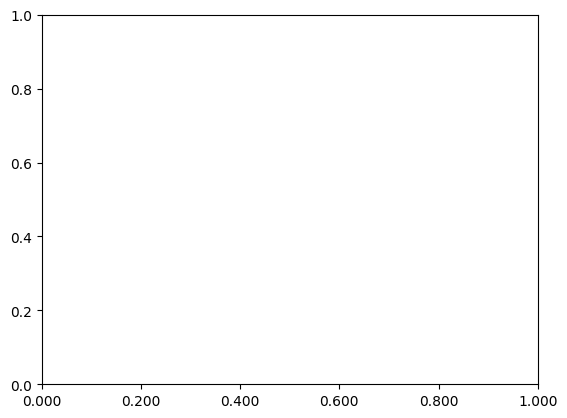

In [33]:
# ==========================================
# 5. VISUALIZAÇÃO
# ==========================================
# Garante que o diretório de dados existe para salvar a imagem
os.makedirs('data', exist_ok=True)

from matplotlib.ticker import FormatStrFormatter
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

try:
    # Gráfico de completude
    plt.figure(figsize=(12, 7))
    completude_por_coluna = (df.count() / len(df) * 100).sort_values()
    completude_por_coluna.plot(kind='barh', color='skyblue')
    plt.xlabel('Completude (%)')
    plt.title('Completude dos Dados por Coluna', fontsize=14)
    plt.xlim(0, 100)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('data/quality_report_completude.png')
    plt.close()
    print("\nGráfico de completude salvo em: data/quality_report_completude.png")

# Gráfico de Distribuição de Rendimento (Yield) - Scatter Plot (Gráfico de Dispersão)
    plt.figure(figsize=(10, 6))
    y_jitter = np.random.normal(0, 0.05, size=len(df))
    plt.scatter(df['Yield'], y_jitter, s=5, alpha=0.5, color='darkgreen')
    plt.title('Distribuição de Rendimento (Yield) - Scatter Plot com Jitter')
    plt.xlabel('Yield')
    plt.ylabel('Densidade de Pontos (Jitter)')
    plt.yticks([])
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    plt.tight_layout()
    plt.savefig('data/quality_report_yield_distribution.png')
    plt.close()
    print("Gráfico de distribuição de Yield salvo em: data/quality_report_yield_distribution.png")

# Gráfico de Distribuição de Produção (Production) - Scatter Plot (Gráfico de Dispersão)
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Production'], y_jitter, s=5, alpha=0.5, color='darkred')
    plt.title('Distribuição de Produção (Production) - Scatter Plot com Jitter')
    plt.xlabel('Production')
    plt.ylabel('Densidade de Pontos (Jitter)')
    plt.yticks([]) # Remove a escala do eixo Y, pois a dispersão é artificial
    plt.ylim(-0.1, 0.1) # Limita o eixo Y para manter o foco na linha central
    plt.tight_layout()
    plt.savefig('data/quality_report_production_distribution.png')
    plt.close()
    print("Gráfico de distribuição de Production salvo em: data/quality_report_production_distribution.png")

except Exception as e:
    print(f"Aviso: Não foi possível gerar gráficos. Erro: {e}")

In [17]:
# Score simples: média de completude e unicidade
score_final = (completude_geral + unicidade) / 2
print(f"Score Final: {score_final:.2f}%")

Score Final: 100.00%


In [34]:
if score_final >= 95:
    print("Classificação: EXCELENTE")
elif score_final >= 85:
    print("Classificação: BOM")
elif score_final >= 75:
    print("Classificação: REGULAR")
else:
    print("Classificação: NECESSITA MELHORIAS")

Classificação: EXCELENTE
